# Algorithm comparison

Identify the best machine learning algorithm for predicting what category a chemical from the test set belongs to

### Get the data  from [property_calculations](property_calculations.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path as path
import pickle
from data_paths import BASE_PATH

# Load property_array from property_calculations FEMA-JECFA database
dataset_path = path.join(BASE_PATH,
                         'fp',
                         'property_calculations',
                         'dataset.pkl')

with open(dataset_path, 'rb') as f:
    dataset = pickle.load(f)
    
train_features = dataset['train features']
train_labels = dataset['train labels']

### Test on different classifiers

In [2]:
#Scoring function
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score,\
                            precision_score, recall_score
import scipy.stats as st
import warnings

def t_delta(percent, scores):
    """
    Returns the size of a t-test error bar that defines a given percent confidence interval 
    """
    mean, sem = np.mean(scores), st.sem(scores)
    interval = st.t.interval(percent/float(100), len(scores)-1, loc=mean, scale=sem)
    delta = mean - interval[0]
    return delta


def scores(clf,
           features, labels,
           score_types, 
           title='estimator', printout=True):
    """
    Generates a dictionary with cross_validation scores  and summary statistics
    for a given clf (estimator), features, and labels
    """
    
    if printout:
        print('\n{}:' .format(title))
    
    summary_dict = {title: {}}

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=41)

    for scoring in score_types:
        scores = cross_val_score(clf, features, labels, cv=cv, scoring=scoring)
        mean =  np.mean(scores)
        # t-test 95% confidence interval
        delta = t_delta(95, scores)

        summary_dict[title][scoring] = (mean, delta)

        if printout:
            print('-', scoring, scores)
            print('Mean: {:.2f} (+/-{:.2f})' .format(mean, delta))

    return summary_dict

def multi_tester(step_list, clf_list, score_types):
    """
    Runs scores function on all clfs in clf_list.
    Preappends the steps in step_list to make a pipeline with clf at the end.
    Returns a scores list for each clf and a pipe_dict of all the pipes generated
    """
    pipe_dict = {}
    scores_list = []
    for clf in clf_list:
        new_steps = step_list[:]
        new_steps.append(('estimator', clf))
        new_pipe = Pipeline(new_steps)
        title = str(type(clf))    
        title = title.split('.')[-1][:-2]
        pipe_dict[title] = new_pipe
        scores_list.append(scores(new_pipe, train_features,
                                  train_labels, score_types,
                                  title=title, printout=True))
    return scores_list, pipe_dict

Test on these __classifiers__:

1) Naive Bayes (Gaussian, Multinomial, and Bernoulli versions)

2) Support Vector Machines

3) AdaBoost

4) Logistic Regression

5) Multi-layer Perceptron

Note that the data is also __preprocessed__ by:

1) Imputing missing values to the overall feature mean 

2) Using the MinMaxScaler to scale all features to [0,1]. This scaler is used instead of the StandardScaler because it preserves zero entries in sparse data, which are frequent in the chemical fingerprints.

In [38]:
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.feature_selection import SelectPercentile, f_classif

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline

step_list = [('imputer', Imputer(strategy='mean')),
         ('scaler', MinMaxScaler())]

clf_list = [GaussianNB(),
            MultinomialNB(),
            BernoulliNB(binarize=0.5),
            SVC(),
            AdaBoostClassifier(),
            LogisticRegression(class_weight='balanced'),
            MLPClassifier()]

from sklearn.metrics import matthews_corrcoef, make_scorer
math_scorer = make_scorer(matthews_corrcoef)

score_types = ['precision',
               'recall',
               math_scorer]

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    scores_list, pipe_dict = multi_tester(step_list, clf_list, score_types)


GaussianNB:
- precision [ 0.24489796  0.24561404  0.24528302]
Mean: 0.25 (+/-0.00)
- recall [ 0.1875    0.21875   0.203125]
Mean: 0.20 (+/-0.04)
- make_scorer(matthews_corrcoef) [ 0.11687049  0.12770016  0.12225246]
Mean: 0.12 (+/-0.01)

MultinomialNB:
- precision [ 0.34782609  0.42574257  0.37815126]
Mean: 0.38 (+/-0.10)
- recall [ 0.625     0.671875  0.703125]
Mean: 0.67 (+/-0.10)
- make_scorer(matthews_corrcoef) [ 0.36139215  0.44960566  0.41985294]
Mean: 0.41 (+/-0.11)

BernoulliNB:
- precision [ 0.31914894  0.39473684  0.32653061]
Mean: 0.35 (+/-0.10)
- recall [ 0.703125  0.703125  0.75    ]
Mean: 0.72 (+/-0.07)
- make_scorer(matthews_corrcoef) [ 0.36054029  0.43521716  0.38511986]
Mean: 0.39 (+/-0.09)

SVC:
- precision [ 0.  0.  0.]
Mean: 0.00 (+/-nan)
- recall [ 0.  0.  0.]
Mean: 0.00 (+/-nan)
- make_scorer(matthews_corrcoef) [ 0.  0.  0.]
Mean: 0.00 (+/-nan)

AdaBoostClassifier:
- precision [ 0.43396226  0.525       0.575     ]
Mean: 0.51 (+/-0.18)
- recall [ 0.359375  0.32812

### Visualize the different algorithm scores testing

In [4]:
def initialize_plot_dicto(dicto):
    """
    Initialize a flat plot_dicto with keys from dicto and epmty lists
    """
    og_key = list(dicto.keys())[0]
    keys = ['clf'] + list(dicto[og_key].keys())
    plot_dicto = {key: [] for key in keys}
    return plot_dicto

def build_plot_dicto(plot_dicto, scores_list):
    """
    Add values to plot_dicto from scores list
    """
    
    for dicto in scores_list:
        og_key = list(dicto.keys())[0]
        plot_dicto['clf'].append(og_key)
        keys = list(plot_dicto.keys())
        keys.remove('clf')
        for key in keys:
            plot_dicto[key].append(dicto[og_key][key])
    
    return plot_dicto

In [39]:
init_plot_dicto = initialize_plot_dicto(scores_list[0])
plot_dicto = build_plot_dicto(init_plot_dicto, scores_list)
plot_dicto['matthews correlation'] = plot_dicto.pop(math_scorer)
print(plot_dicto)

{'matthews correlation': [(0.12227436872362185, 0.013451281062318937), (0.41028358033841883, 0.11148452760746119), (0.39362577273411964, 0.094541642993374198), (0.0, nan), (0.35439625745532655, 0.098041178244809513), (0.4115489112761519, 0.068470020433001488), (0.41124287991662056, 0.22901537328679747)], 'recall': [(0.203125, 0.038814651747558632), (0.66666666666666663, 0.097681398118920071), (0.71875, 0.067228948904863639), (0.0, nan), (0.34895833333333331, 0.04481929926990913), (0.51041666666666663, 0.080799140824011517), (0.34375, 0.13445789780972733)], 'clf': ['GaussianNB', 'MultinomialNB', 'BernoulliNB', 'SVC', 'AdaBoostClassifier', 'LogisticRegression', 'MLPClassifier'], 'precision': [(0.24526500437977242, 0.00089025952696780708), (0.38390664057271634, 0.097566482739308957), (0.34680546350679126, 0.10352284627887787), (0.0, nan), (0.51132075471698113, 0.17763325269582014), (0.46865823624135644, 0.045940550363301413), (0.61179771816219553, 0.3191548082282914)]}


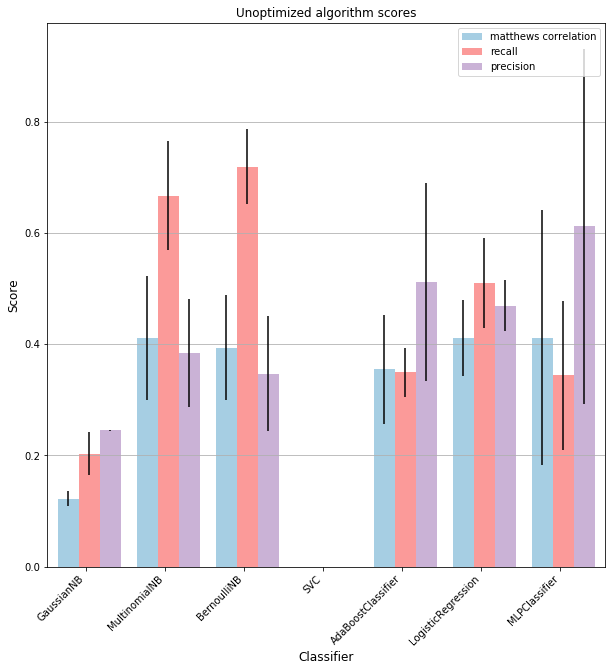

In [50]:
clfs = plot_dicto['clf']
score_list = list(plot_dicto.keys())
score_list.remove('clf')

num_groups = len(clfs)
num_bars = len(score_types)

pos = list(range(num_groups))
width = 1/num_bars - 0.2/num_bars

plt.close('all')
fig, ax = plt.subplots(figsize=(10,10))
cm = plt.get_cmap('Paired')
ax.set_prop_cycle(color=[cm(i/num_bars) for i in range(num_bars)])
for i, score in enumerate(score_list):
    value = plot_dicto[score]
    means, stds = zip(*value)
    plt.bar([p + width*i for p in pos],
            means,
            width,
            yerr=stds,
#             alpha=0.5,
            label=score)

ax.set_ylabel('Score', size=12)
ax.set_xlabel('Classifier', size=12)
ax.set_title('Unoptimized algorithm scores')
ax.set_xticks([p + 0.45/2 for p in pos])
ax.set_xticklabels(clfs, rotation=45, horizontalalignment='right')
ax.yaxis.grid()
plt.xlim(min(pos)-width, max(pos)+width*num_bars)

plt.legend(loc='upper right')
plt.show()

fig.savefig('Images/2_unoptimized_comparison.png')

Proceed with parameter optimization for:

- __Adaboost__
- __Logistic Regression__
- __Multi-layer perceptron__

Support Vector Machines performed badly, and Naive Bayes don't have many parameters to optimize, although its worth noting that the Bernoulli Naive Bayes performed as well, if not better in terms of recall, than the other classifiers.